프로젝트: 고양이 수염 스티커 만들기
=====

Step 1. 스티커 구하기 or 만들기
---------
<br/>
- 스티커는 노드에 있는 flaticon 이미지를 사용하였습니다.

Step 2. 얼굴 검출 & 랜드마크 검출 하기
--------
오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

- opencv,matplotlib & image resize

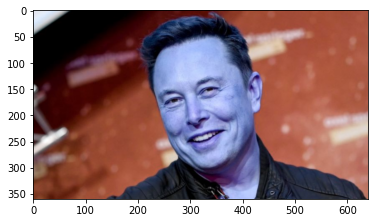

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/musk.jpeg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

- dilb을 활용하여 hog detector 선언 및 bounding box 추출

In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #rgb 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(221, 98) (407, 284)]]


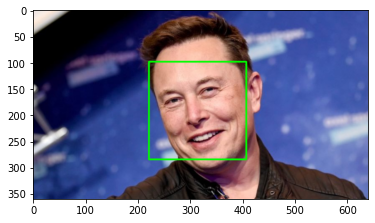

In [3]:
print(dlib_rects)   # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

- landmark 출력

68


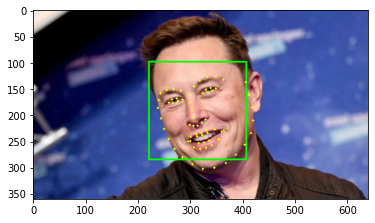

In [4]:
# landmark load
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)


list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts())) #직관적인 x,y 형태로 변환
    list_landmarks.append(list_points)

print(len(list_landmarks[0])) 


for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

Step 3. 스티커 적용 위치 확인하기
------
고양이 수염이 적용 될 볼 위치를 landmark를 사용해서 계산해 주세요.
볼은 '턱', '눈', '입', '코' 사이에 있다는 점을 이용해 주세요. 비율로 계산하는 방법 잊지 않으셨죠?

hint 2, 36, 48, 30 번 인덱스를 이용

- 볼의 위치를 알기위해 landmark 순서 그림을 load

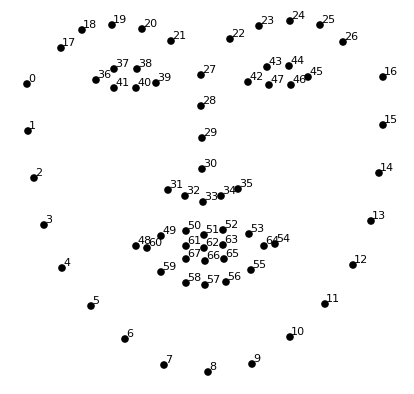

In [5]:
from PIL import Image
import os

landmark_guide = os.getenv('HOME')+'/aiffel/camera_sticker/images/landmark.png'
landmark = Image.open(landmark_guide)
landmark


- 이미지는 볼을 기준으로 잡아야하므로 2 48 30 40 번 인덱스를 이용합니다

In [6]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print ('left :',landmark[2],'top :',landmark[36],'right :',landmark[30],'bottom :',landmark[48]) 
    left_x = landmark[2][0] # left index : 2
    left_y = landmark[2][1] - dlib_rect.width()//2 
    top_x = landmark[36][0] # top index : 36
    top_y = landmark[36][1] - dlib_rect.width()//2 
    right_x = landmark[30][0] # right index : 30
    right_y = landmark[30][1] - dlib_rect.width()//2 
    bottom_x = landmark[48][0] # bottom index : 48
    bottom_y = landmark[48][1] - dlib_rect.width()//2
    x = ((left_x + right_x) //2)
    y = ((top_y + bottom_y) // 2)
    w = dlib_rect.width()
    h = dlib_rect.height()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

left : (250, 226) top : (259, 176) right : (305, 205) bottom : (296, 250)
(x,y) : (277,120)
(w,h) : (187,187)


- 위에서 계산한 w,h 값으로 resize

In [7]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


- 이미지의 시작점은 top-left 이므로 x,y 좌표를 조정

In [19]:
refined_x = x - w // 2  # left
refined_y = y  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (184,-67)


In [20]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(83, 187, 3)
(x,y) : (184,0)


(150, 187, 3)


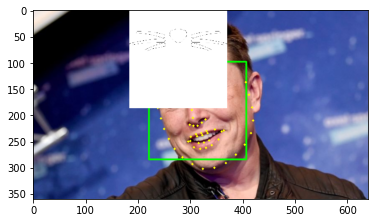

In [18]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

print (sticker_area.shape)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

Step 4. 스티커 적용하기
------
(1) 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

(2) 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다.
opencv 의 cv2.addWeighted() 를 참고하세요.

Step 5. 문제점 찾아보기
------

(1) 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
실행 속도가 중요할까요?
스티커앱을 만들 때 정확도가 얼마나 중요할까요?